# Data Analysis and Visualization

Importing libraries, setting up spark session and Loading Data

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Pyspark Modelling") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df = spark.read.csv('Data/Cleaned_data.csv', header= True, inferSchema= True, multiLine=True, quote='"', escape='"')

Exploring data

In [2]:
df.printSchema()
df.show(5)
df.count()

root
 |-- Desc: string (nullable = true)
 |-- hostID: integer (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: double (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- host_listings: integer (nullable = true)
 |-- availability: integer (nullable = true)
 |-- city: string (nullable = true)

+--------------------+--------+-------------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+-------------+------------+---------+
|                Desc|  hostID|neighbourhood_group|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|reviews_per_month|host_listings|availability|     city|
+--------------------+--------+-------------------+--------+---------+----

Seperating continuous and categorial(string type) features and looking into the stats of continuou features.

In [3]:
Cont_features = ['longitude', 'latitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',\
                 'host_listings','availability']
Cat_featues = ['neighbourhood_group', 'room_type', 'city']

In [4]:
df.select(Cont_features).describe().show()

+-------+-------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+
|summary|          longitude|          latitude|            price|    minimum_nights|number_of_reviews| reviews_per_month|     host_listings|      availability|
+-------+-------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+
|  count|             225672|            225672|           225672|            225672|           225672|            225672|            225672|            225672|
|   mean|-103.22200103468332|35.663568296288986|219.8500124073877|453.20938796128894|34.55566485873303|1.1252707026125244|16.314509553688538|159.06887429543764|
| stddev| 26.235524064831257| 6.851602153813388|570.7892001102556| 210504.3720862463|63.62125619748662| 1.603421807263239|49.342211123319416|140.09229010914888|
|    min|          -159.7149|     

Drawing density plots of all continuous features to look for outliers and ambiguities.

In [45]:
#converting continuous features to pandas dataframe
cont_df = df.select(Cont_features).toPandas()

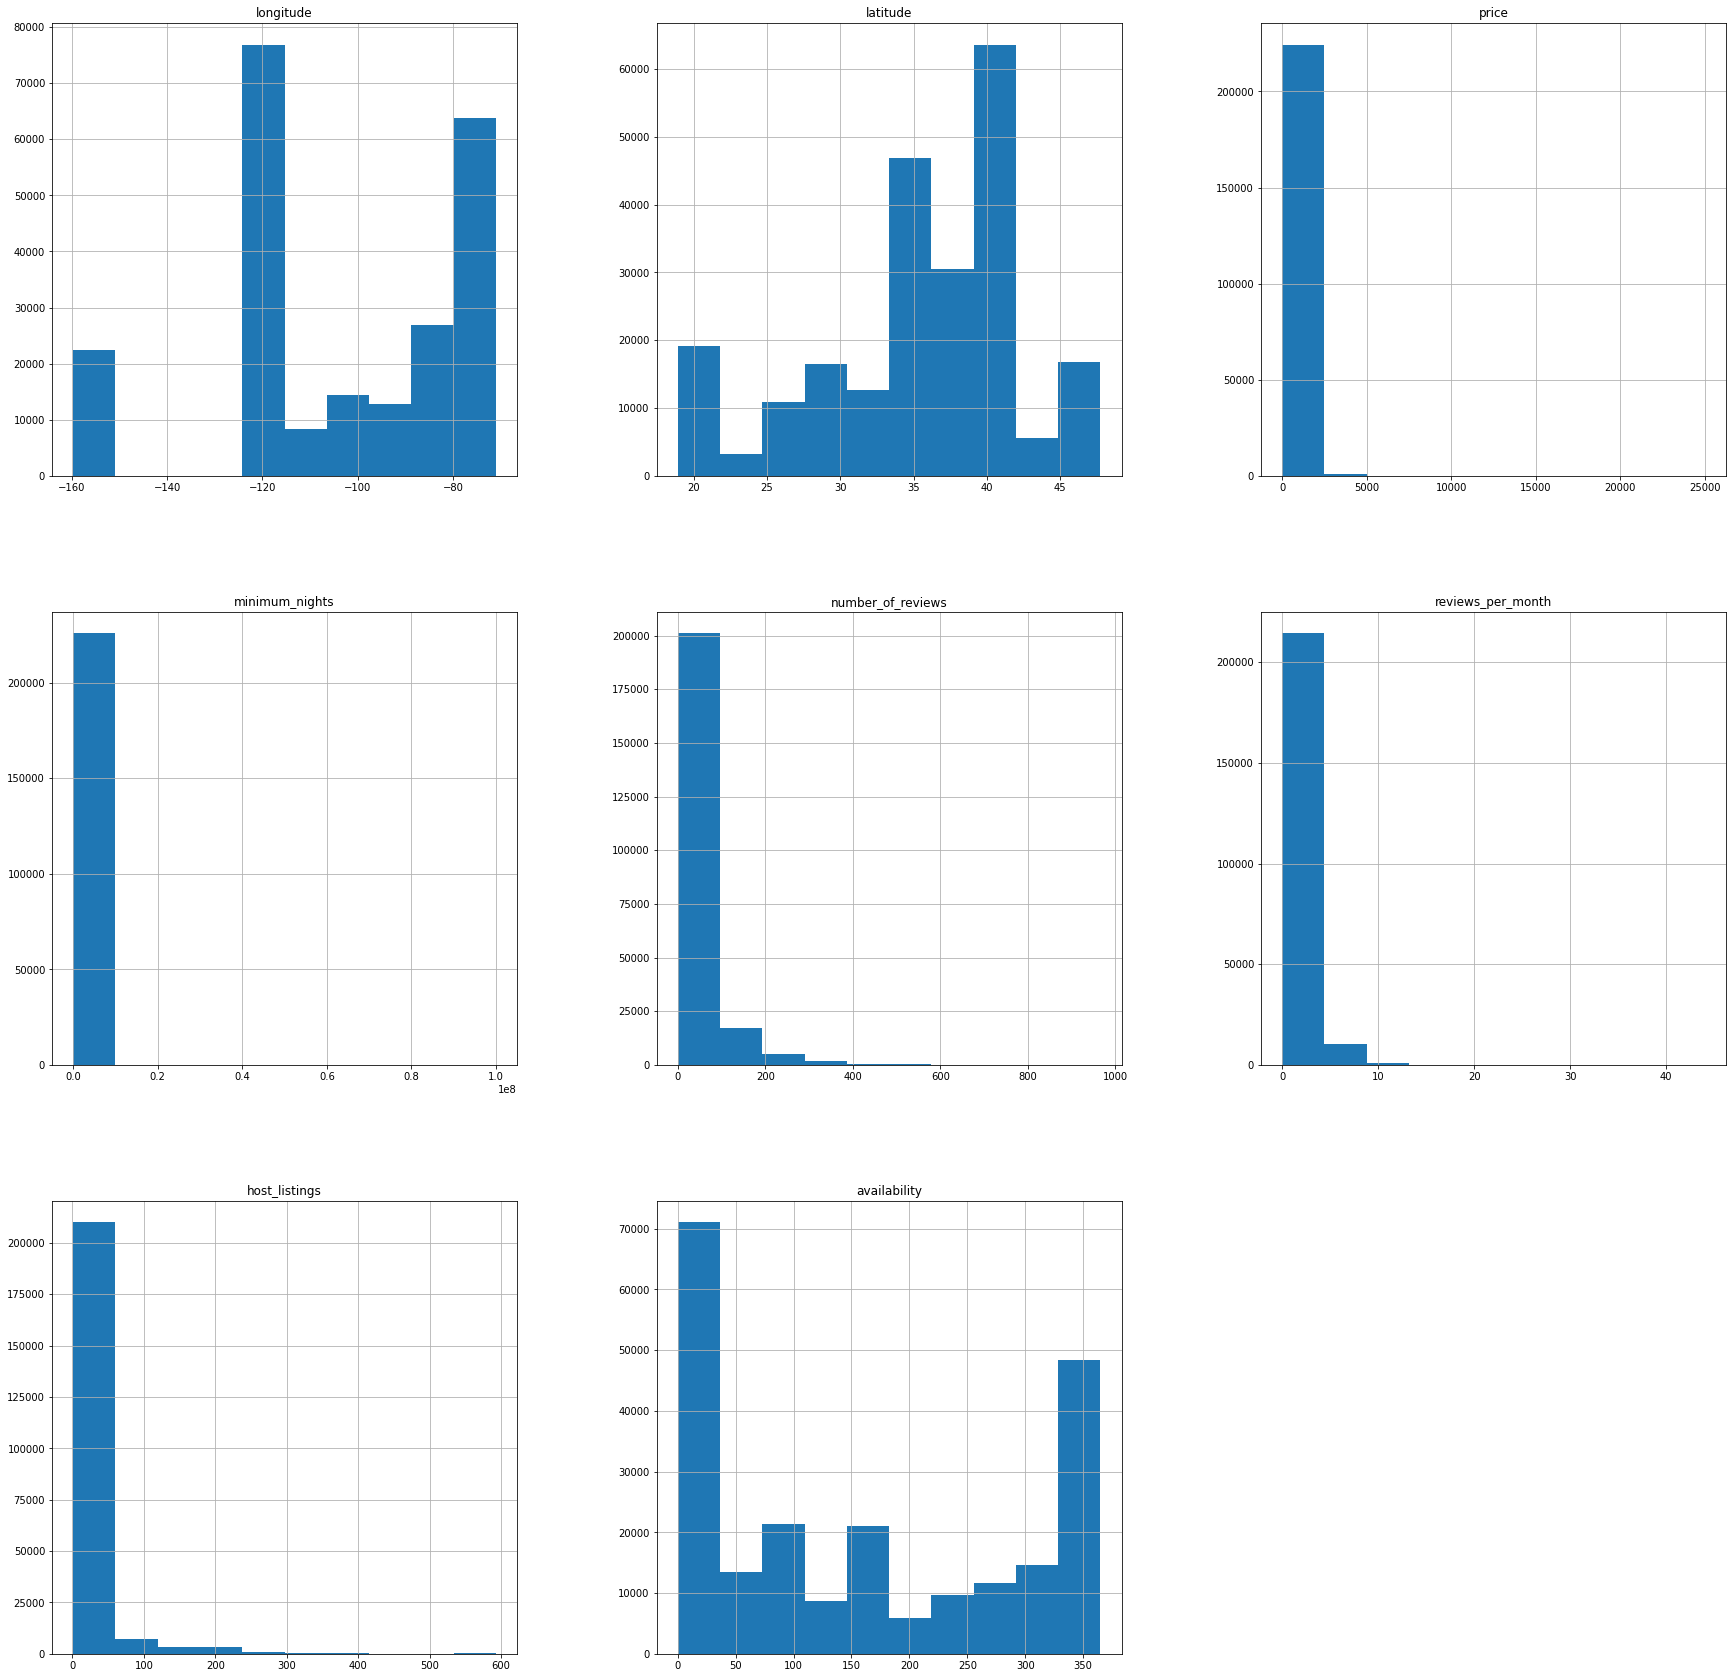

In [46]:
cont_df.hist(figsize=(30, 30))
plt.savefig('Figures/Histogram_grid.png')


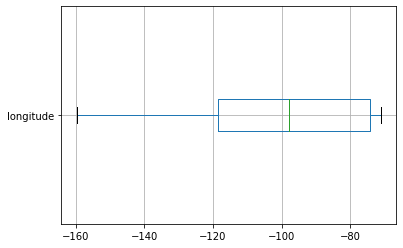

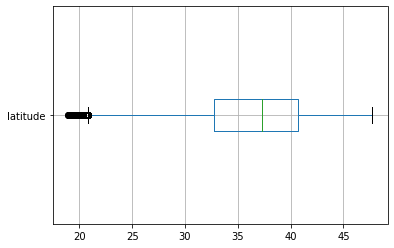

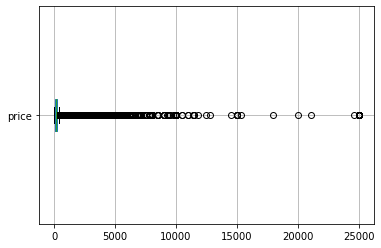

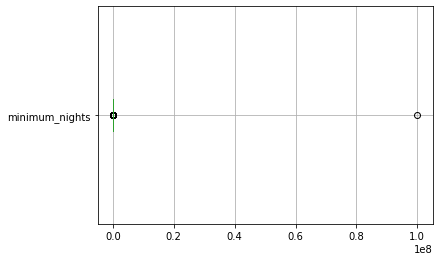

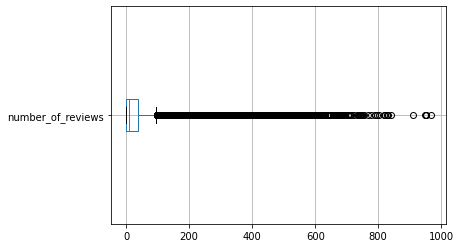

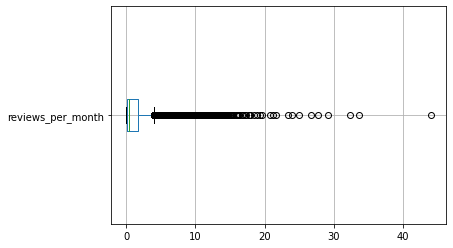

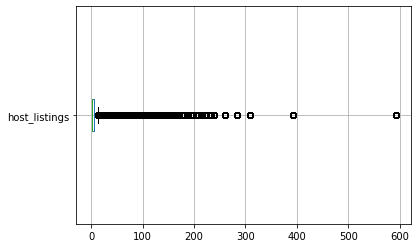

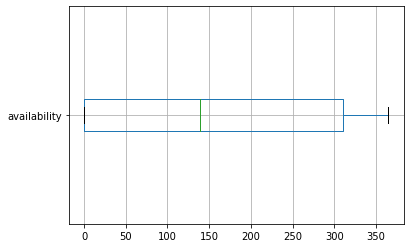

In [47]:
#Boxplot of all continuous features
for features in Cont_features:
    plt.figure()
    cont_df.boxplot([features], vert=False)

From density plots and stats matrix, we can see that price attribute has some listings with 0 price. Lets delete those listings and save the changes.

In [ ]:
#Deleting entries with 0 price
import pyspark.sql.functions as F
df = df.filter(F.col('price')!=0)
df.count()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|           225672|
|   mean|219.8500124073877|
| stddev|570.7892001102556|
|    min|              0.0|
|    max|          24999.0|
+-------+-----------------+



<AxesSubplot:>

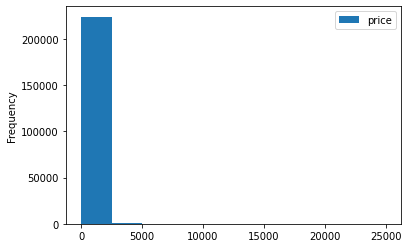

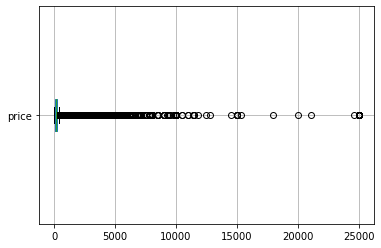

In [48]:
#inspecting price attribute again
x = df.select('price').toPandas() 
x.plot(kind='hist')
df.select('price').describe().show()
plt.figure()
cont_df.boxplot(['price'], vert=False)

In [52]:
#saving changes to csv file
dfp = df.toPandas()
dfp.to_csv('Data/Cleaned_data.csv', index=False)

# Exploring Categorial features

Room_type data

In [53]:
room_type_cat = df.groupBy('room_type').count()
room_type_cat.show()

+---------------+------+
|      room_type| count|
+---------------+------+
|    Shared room|  4024|
|     Hotel room|  1901|
|Entire home/apt|153836|
|   Private room| 65849|
+---------------+------+



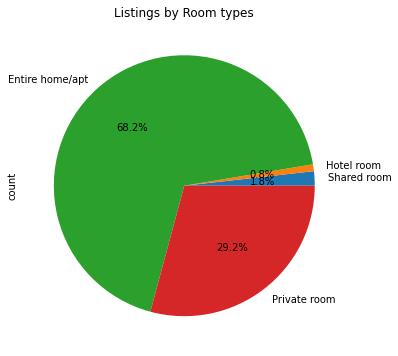

In [63]:
import pandas as pd
room_type_data_pd = room_type_cat.toPandas()
room_type_data_pd.index = room_type_data_pd['room_type']
plt = room_type_data_pd.plot.pie(y='count', autopct='%1.1f%%', legend = False, title='Listings by Room types', figsize=(16,6))

<BarContainer object of 4 artists>

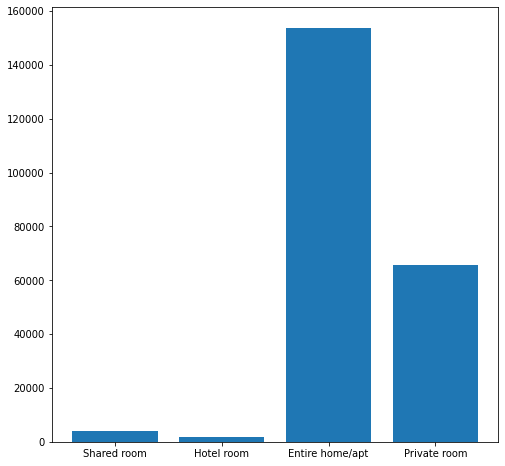

In [92]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
axs.bar(room_type_data_pd['room_type'], room_type_data_pd['count'])

Neighbourhood Data

In [64]:
neighbourhood_group_cat = df.groupby("neighbourhood_group").count()
neighbourhood_group_cat.orderBy(neighbourhood_group_cat["count"].desc()).show()

+--------------------+------+
| neighbourhood_group| count|
+--------------------+------+
|             Unknown|115571|
|           Manhattan| 20203|
|            Brooklyn| 18256|
| City of Los Angeles| 17497|
|        Other Cities| 11449|
|                Maui|  7897|
|            Honolulu|  6312|
|              Queens|  5745|
|              Hawaii|  4977|
|               Kauai|  3247|
|Unincorporated Areas|  2523|
|             Newport|  1412|
| Other neighborhoods|  1253|
|          Washington|  1201|
|               Bronx|  1184|
|          Providence|  1056|
|            Downtown|  1043|
|        Capitol Hill|   681|
|        Central Area|   572|
|          Queen Anne|   459|
+--------------------+------+
only showing top 20 rows



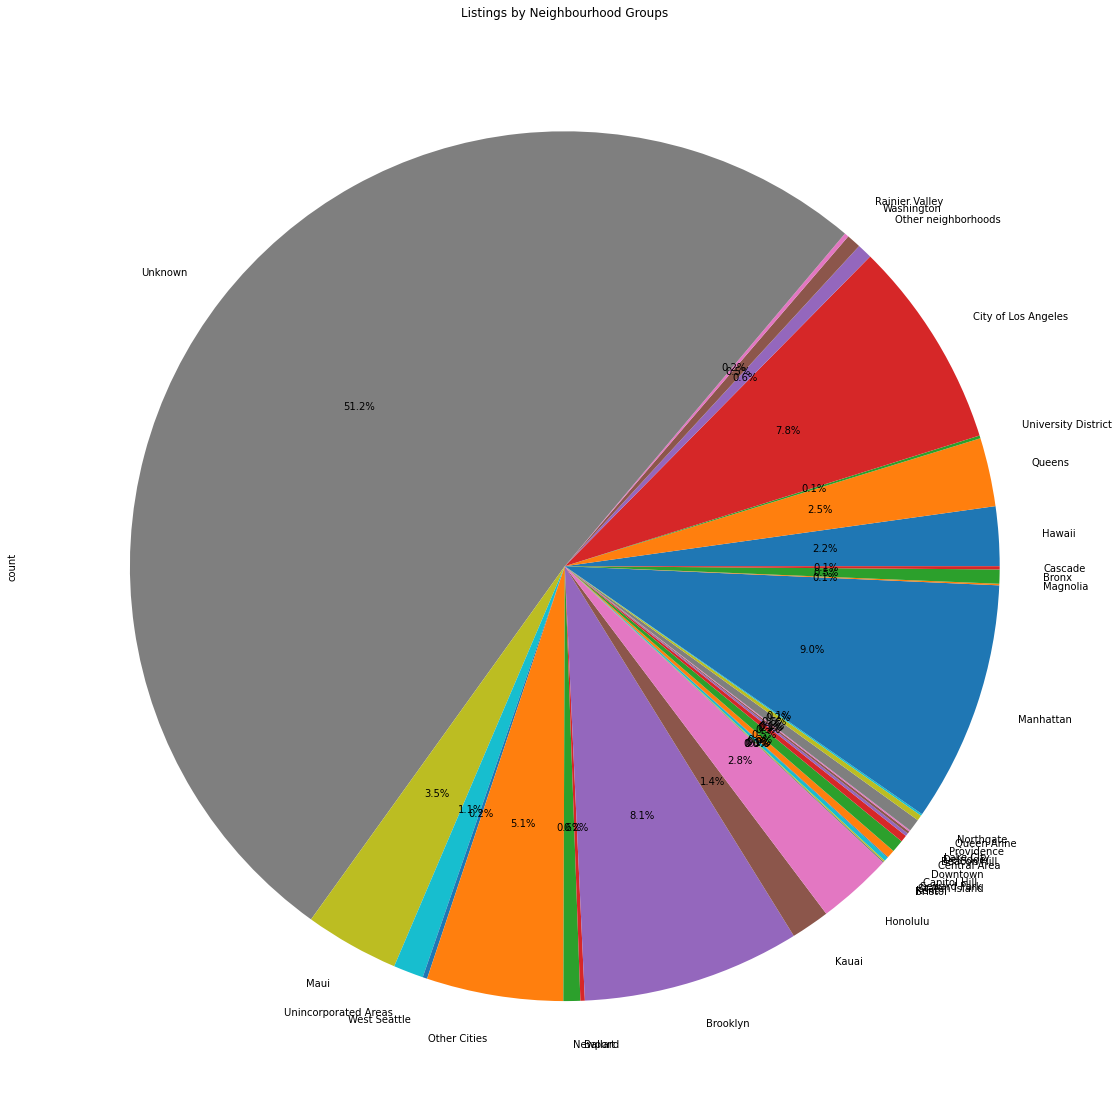

In [65]:
neighbourhood_group_cat_pd = neighbourhood_group_cat.toPandas()
neighbourhood_group_cat_pd.index = neighbourhood_group_cat_pd['neighbourhood_group']
plt = neighbourhood_group_cat_pd.plot.pie(y='count', autopct='%1.1f%%', legend = False, title='Listings by Neighbourhood Groups', figsize=(20,20))

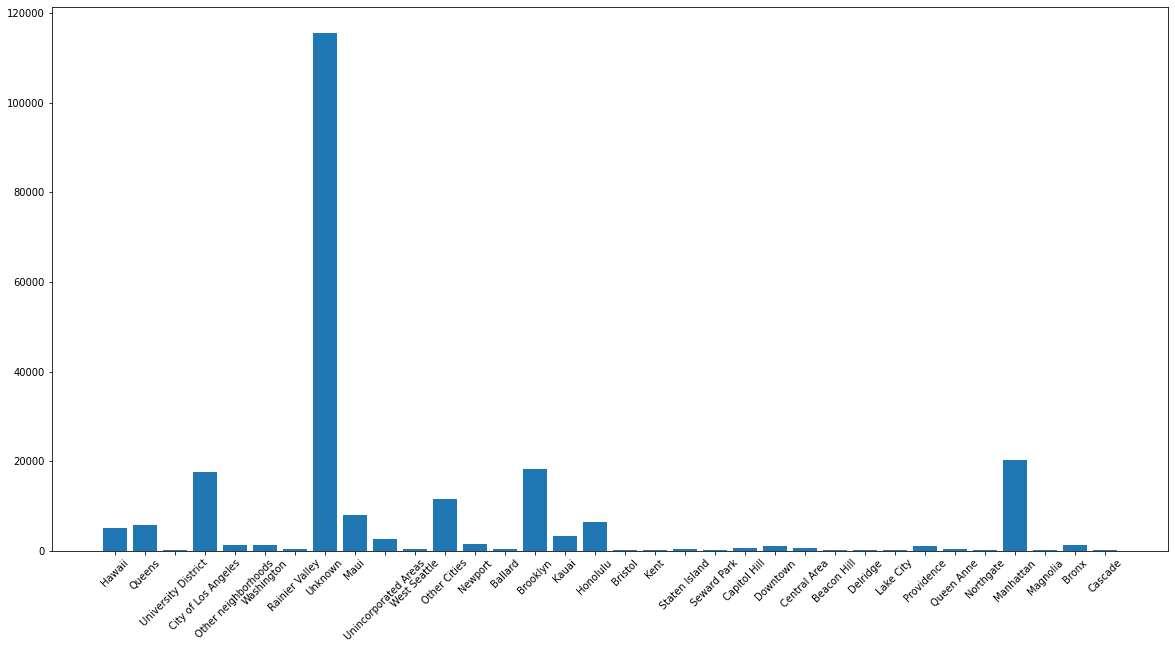

In [81]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.bar(neighbourhood_group_cat_pd['neighbourhood_group'], neighbourhood_group_cat_pd['count'])
axs.tick_params(axis='x', labelrotation = 45)

City data

In [66]:
city_cat = df.groupby("city").count()
city_cat.orderBy(city_cat["count"].desc()).show()

+-----------------+-----+
|             city|count|
+-----------------+-----+
|    New York City|45714|
|      Los Angeles|31469|
|           Hawaii|22433|
|        San Diego|12402|
|   Broward County|10854|
|           Austin|10318|
|     Clark County| 8361|
|  Washington D.C.| 7330|
|San Clara Country| 7090|
|    San Francisco| 7044|
|          Seattle| 6539|
|  Twin Cities MSA| 6462|
|          Chicago| 6396|
|      New Orleans| 6376|
|        Nashville| 6136|
|         Portland| 4280|
|           Denver| 4198|
|     Rhode Island| 3884|
|           Boston| 3325|
|          Oakland| 3203|
+-----------------+-----+
only showing top 20 rows



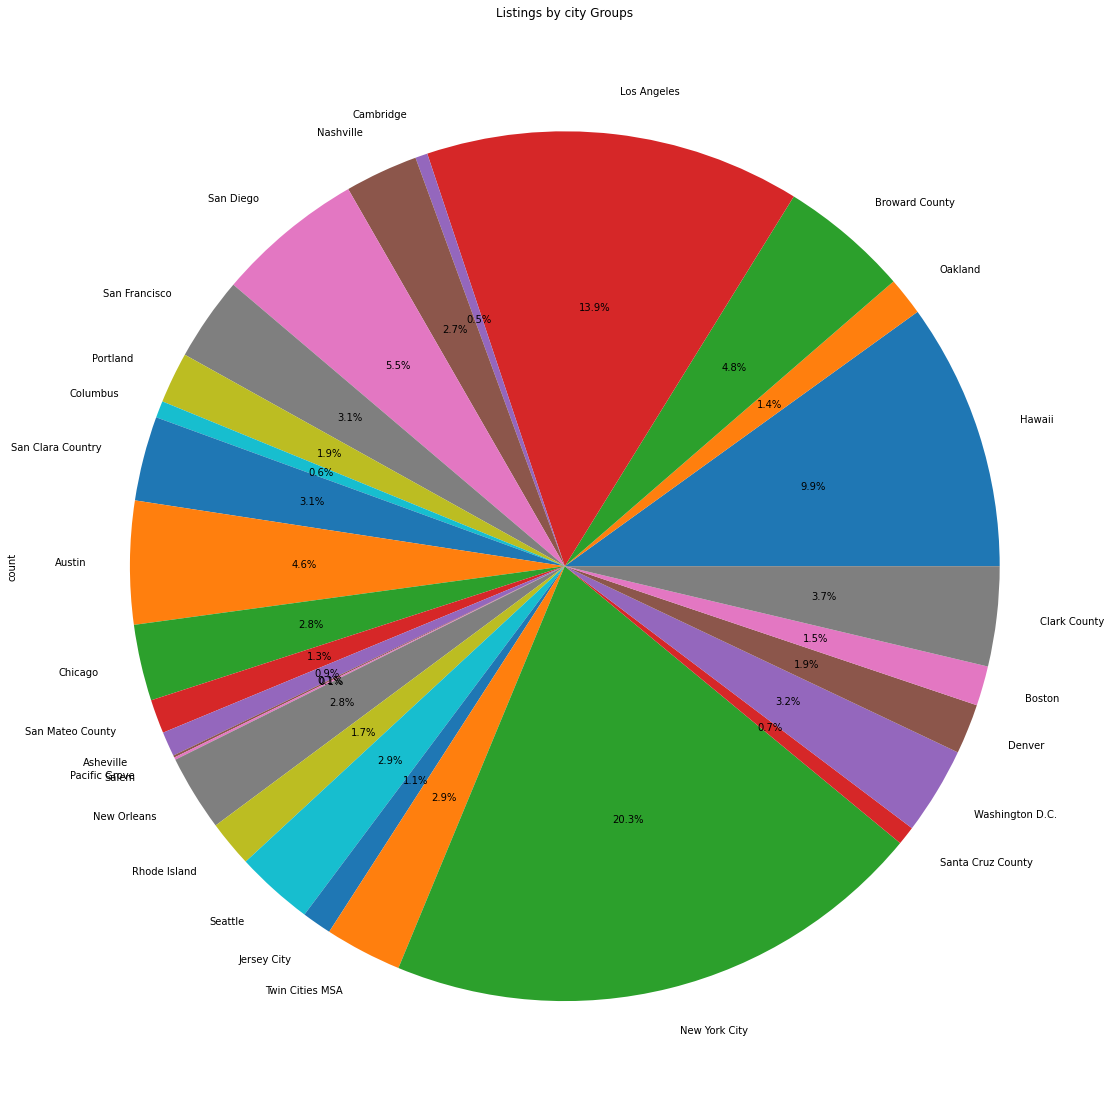

In [68]:
city_cat_pd = city_cat.toPandas()
city_cat_pd.index = city_cat_pd['city']
plt = city_cat_pd.plot.pie(y='count', autopct='%1.1f%%', legend = False, title='Listings by city Groups', figsize=(20,20))

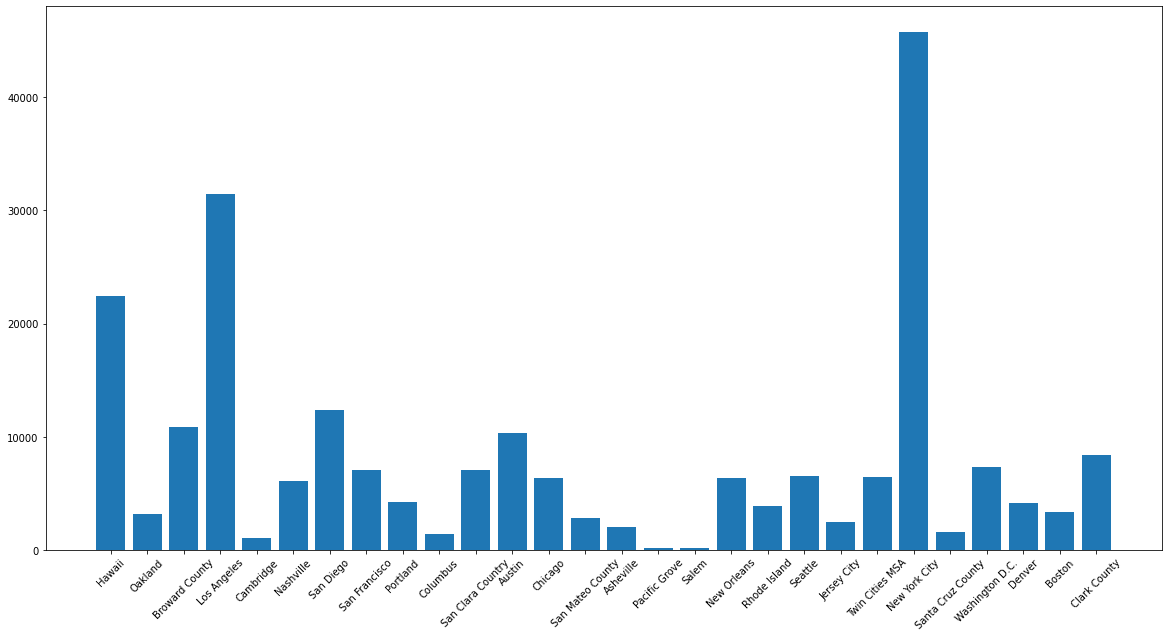

In [70]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.bar(city_cat_pd['city'], city_cat_pd['count'])
axs.tick_params(axis='x', labelrotation = 45)

Combining room_type and city data

In [85]:
city_room_type_schema = df.select(df["city"], df["room_type"]).show()

+---------+---------------+
|     city|      room_type|
+---------+---------------+
|Asheville|Entire home/apt|
|Asheville|   Private room|
|Asheville|   Private room|
|Asheville|Entire home/apt|
|Asheville|Entire home/apt|
|Asheville|Entire home/apt|
|Asheville|Entire home/apt|
|Asheville|Entire home/apt|
|Asheville|Entire home/apt|
|   Austin|Entire home/apt|
|   Austin|   Private room|
|   Austin|Entire home/apt|
|   Austin|Entire home/apt|
|   Austin|Entire home/apt|
|   Austin|   Private room|
|   Austin|Entire home/apt|
|   Austin|   Private room|
|   Austin|Entire home/apt|
|   Austin|Entire home/apt|
|   Austin|Entire home/apt|
+---------+---------------+
only showing top 20 rows



In [86]:
# room type by city.
city_roomtype = df.select(df["city"], df["room_type"]).groupBy("city", "room_type").count()
#city_roomtype.show()

<AxesSubplot:xlabel='city'>

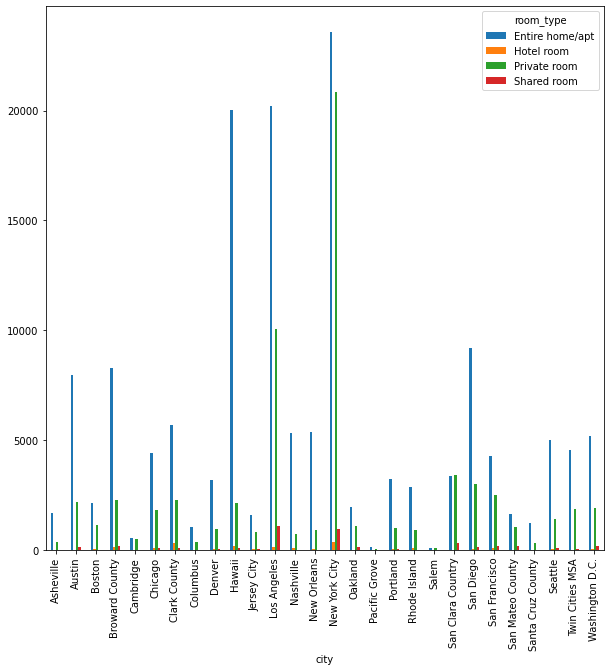

In [91]:
city_roomtype_pd = city_roomtype.toPandas()
pd.pivot_table(city_roomtype_pd, index='city', columns='room_type', values='count').plot.bar(figsize=(10,10))


Visualizing scatterplots of continuous features vs price 

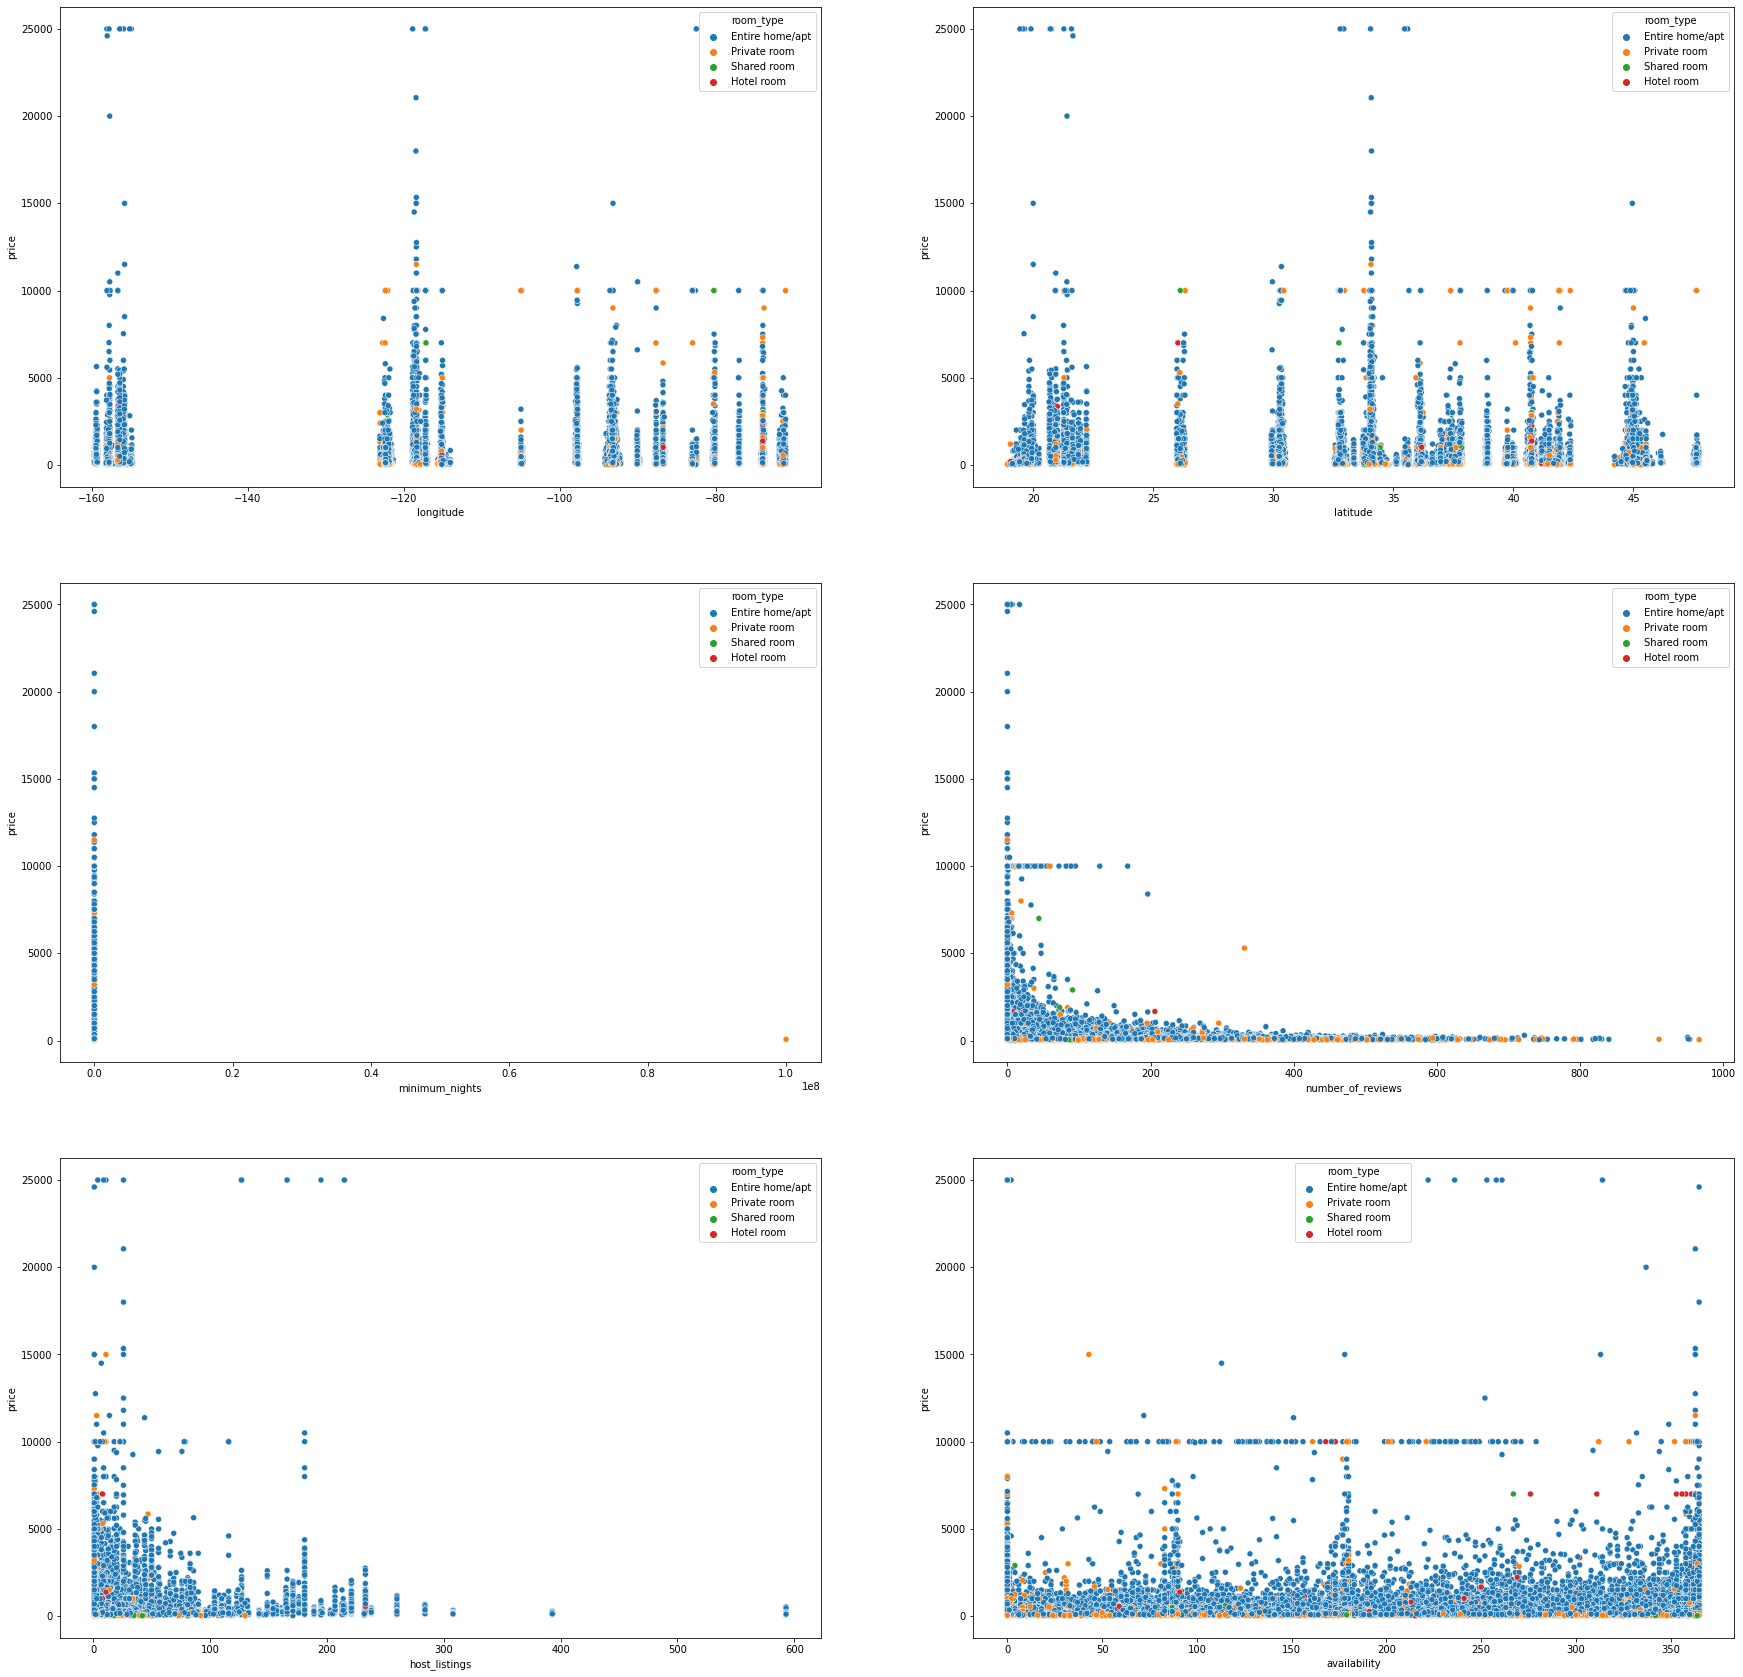

<Figure size 432x288 with 0 Axes>

In [124]:
cf = ['longitude', 'latitude', 'minimum_nights', 'number_of_reviews','host_listings','availability']
c=1
plt.subplots(figsize=(30, 30))
for i in cf:
    plt.subplot(3,2, c)
    sns.scatterplot(x=i, y='price' , data=dfp, hue='room_type')
    c+=1
plt.show()
plt.savefig('Figures/Scatter_grid.png')

Exploring hostID feature

In [93]:
host_id_schema = df.groupBy(df["hostID"]).count()
host_id_schema.orderBy(host_id_schema["count"].desc()).show()

+---------+-----+
|   hostID|count|
+---------+-----+
| 48005494| 1189|
|107434423| 1172|
|  8534462|  582|
|359036978|  486|
| 30283594|  332|
|194953121|  285|
|  2154262|  284|
|359066913|  277|
|229095817|  274|
| 10981379|  270|
|  9419684|  265|
|111808435|  260|
| 30787515|  244|
| 12018637|  233|
| 18476866|  233|
|101401250|  221|
|342643084|  217|
| 51017586|  215|
| 15820446|  213|
| 70195733|  207|
+---------+-----+
only showing top 20 rows



In [146]:
#visualizing hosts with top listings
top_host_id = dfp['hostID'].value_counts().head(10)

[Text(0, 0, '48005494'),
 Text(1, 0, '107434423'),
 Text(2, 0, '8534462'),
 Text(3, 0, '359036978'),
 Text(4, 0, '30283594'),
 Text(5, 0, '194953121'),
 Text(6, 0, '2154262'),
 Text(7, 0, '359066913'),
 Text(8, 0, '229095817'),
 Text(9, 0, '10981379')]

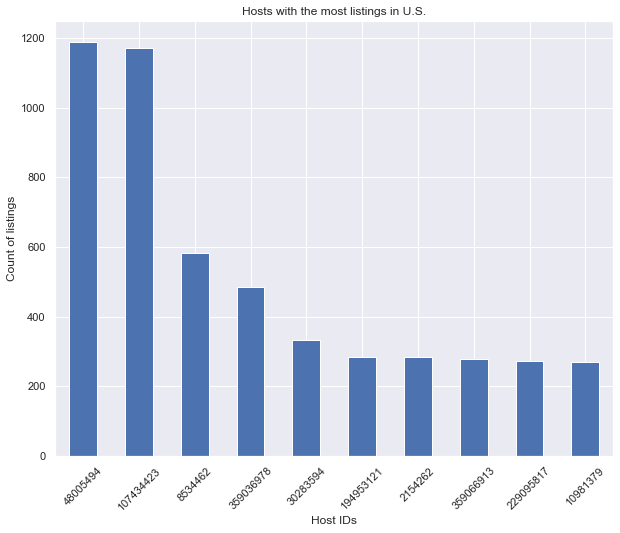

In [143]:
sns.set(rc={'figure.figsize':(10,8)})
viz_bar = top_host_id.plot(kind='bar')
viz_bar.set_title('Hosts with the most listings in U.S.')
viz_bar.set_xlabel('Host IDs')
viz_bar.set_ylabel('Count of listings')
viz_bar.set_xticklabels(viz_bar.get_xticklabels(), rotation=45)

In [107]:
#Unique values of all continuous features
for features in Cont_features:
    count = df.select(features).distinct().count()
    print("Distinct values of" , features, "is", count)

Distinct values of longitude is 145195
Distinct values of latitude is 145035
Distinct values of price is 1974
Distinct values of minimum_nights is 169
Distinct values of number_of_reviews is 660
Distinct values of reviews_per_month is 1242
Distinct values of host_listings is 142
Distinct values of availability is 366


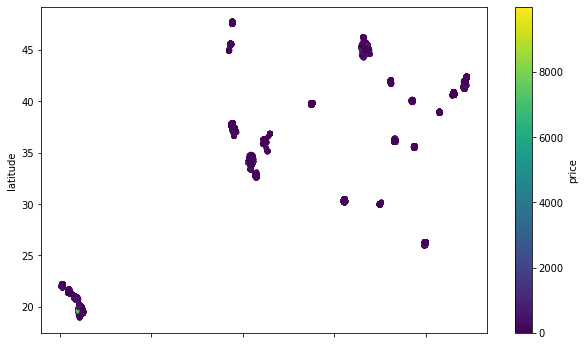

In [114]:
#visualizing listings with price less than 10,000 on map
import matplotlib.pyplot as matp
df_pd_trimmed = cont_df[cont_df['price'] < 10000]
df_pd_trimmed.plot.scatter(x='longitude', y='latitude', c='price', cmap=matp.get_cmap('viridis'), figsize=(10,6))
plt.savefig('Figures/cheap_price_listings.png')